In [20]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from functools import lru_cache
import evaluate
from tqdm import tqdm

In [44]:
@lru_cache(maxsize=512)
def generate_clause_heading_pipeline_single(clause, summarizer, max_length=6, min_length=2, max_input_length = 512):
    """
    Generate a heading for a single clause using the summarization pipeline.
    Args:
        clause (str): A single clause text.
        summarizer (pipeline): Hugging Face summarization pipeline.
        max_length (int): Maximum length of the generated heading.
        min_length (int): Minimum length of the generated heading.
        max_input_length(int): Maximum length of the input text.
    Returns:
        str: The generated heading.
    """
    tokenized_length = len(clause.split())

    # Truncate the clause if it's too long
    if tokenized_length > max_input_length:
        clause = " ".join(clause.split()[:max_input_length])

    # Generate the summary
    try:
        summary = summarizer(clause, max_length=max_length, min_length=min_length, do_sample=False)[0]["summary_text"]
    except Exception as e:
        return f"Error generating heading: {str(e)}"

    return summary

### Sanity

In [3]:
clauses = [
    "The system shall detect and report any failure in the primary sensor within 10 milliseconds to avoid false readings.",
    "All redundant control channels must undergo cross-verification every 5 seconds to ensure functional safety and prevent system failure.",
    "Software components handling safety-critical tasks must log events and errors in compliance with ISO 26262 Part 6, Section 9."
]

In [42]:
summarizer = pipeline("summarization", model="google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [43]:
heading = generate_clause_heading_pipeline_single(clauses[0], summarizer= summarizer)
print(f"{heading}")

The purpose of this


In [5]:
from keybert import KeyBERT

In [6]:
# Function to generate keyword-based heading for a single clause
def generate_keyword_heading(clause, num_kw=5, num_kw_to_return=1, kw_model: KeyBERT = None):
    """
    Generate a keyword-based heading for a single clause.
    
    Args:
        clause (str): The clause text.
        num_keywords (int): Number of keywords to extract for the heading.
        
    Returns:
        str: A keyword-based heading.
    """
    
    keywords = kw_model.extract_keywords(clause, keyphrase_ngram_range=(1, 3), top_n=num_kw)
    
    keywords_text = ", ".join([kw[0] for kw in keywords[:num_kw_to_return]])  # Join top keywords into a heading
    return keywords_text

In [11]:
model = KeyBERT('all-MiniLM-L6-v2')
heading = generate_keyword_heading(clauses[0], num_kw=3, num_kw_to_return=1, kw_model=model)
print(f"{heading}")

failure primary sensor


### Load data

In [12]:
from pathlib import Path

In [13]:
data_dir = Path().cwd().parent.joinpath('data')

In [14]:
file_path = data_dir.joinpath('output/ISO26262-8_df.csv')

In [15]:
df = pd.read_csv(file_path, index_col=0)

In [16]:
df.head()

,Number,Heading,Clause
0,1,Scope,This document is intended to be applied to saf...
1,2,Normative references,The following documents are referred to in the...
2,3,Terms and definitions,"For the purposes of this document, the terms, ..."
3,4,Requirements for compliance,NaN
4,4.1,Purpose,This clause describes how: - a) to achieve com...


In [17]:
df.shape

(139, 3)

## Generate headings

In [31]:
df["Clause"] = df["Clause"].fillna("")

### keybert

In [32]:
kw_model = KeyBERT('all-MiniLM-L6-v2')

In [33]:
tqdm.pandas()

In [34]:
df["Keybert-all-MiniLM-L6-v2"] = df["Clause"].progress_apply(lambda clause: generate_keyword_heading(str(clause), kw_model=kw_model))

100%|██████████| 139/139 [00:28<00:00,  4.84it/s]


In [35]:
df.head()

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2
0,1,Scope,This document is intended to be applied to saf...,safety related systems
1,2,Normative references,The following documents are referred to in the...,functional safety automotive
2,3,Terms and definitions,"For the purposes of this document, the terms, ...",iec maintain terminological
3,4,Requirements for compliance,,
4,4.1,Purpose,This clause describes how: - a) to achieve com...,compliance iso 26262


### pegasus

In [51]:
pegasus_summarizer = pipeline("summarization", model="google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [45]:
df["summarizer-pegasus-xsum"] = df["Clause"].progress_apply(lambda clause: generate_clause_heading_pipeline_single(clause, pegasus_summarizer, max_length=20, min_length=1))

100%|██████████| 139/139 [03:27<00:00,  1.49s/it]


In [47]:
df.head(20)

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2,summerizer-pegasus-xsum
0,1,Scope,This document is intended to be applied to saf...,safety related systems,This document is part of the ISO 26
1,2,Normative references,The following documents are referred to in the...,functional safety automotive,ISO 26262-1 Road vehicles - Functional
2,3,Terms and definitions,"For the purposes of this document, the terms, ...",iec maintain terminological,The International Electrotechnical Commission ...
3,4,Requirements for compliance,,,A selection of photos from around the world
4,4.1,Purpose,This clause describes how: - a) to achieve com...,compliance iso 26262,This clause describes how: - a)
5,4.2,General requirements,When claiming compliance with the ISO 26262 se...,compliance iso 26262,ISO 26262 is a series of standards
6,4.3,Interpretations of tables,Tables are normative or informative depending ...,table methods listed,The following table lists the recommended meth...
7,4.4,ASIL-dependent requirements and recommendations,The requirements or recommendations of each su...,asil given parentheses,"ISO 26262-9:2018, Clause"
8,4.5,Adaptation for motorcycles,For items or elements of motorcycles for which...,motorcycles requirements iso,This document has been prepared in accordance ...
9,4.6,"Adaptation for trucks, buses, trailers and sem...",Content that is intended to be unique for truc...,trucks buses trailers,The following content is copyrighted.


### T5

In [50]:
t5_summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")

Device set to use cpu


In [52]:
df["summarizer-t5-small"] = df["Clause"].progress_apply(lambda clause: generate_clause_heading_pipeline_single(clause, t5_summarizer, max_length=10, min_length=1))

100%|██████████| 139/139 [00:28<00:00,  4.89it/s]


In [63]:
df.iloc[90:110]

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2,summerizer-pegasus-xsum,summerizer-t5-small
90,14.4.4.2,Modifications to items introduced for a future...,Modifications to items and their environment i...,comply iso 26262,Changes to items and their environment introdu...,"ISO 26262-2:2018, 6.4.3"
91,14.4.4.3,Modifications to elements introduced for a fut...,Modifications to elements and their environmen...,modifications elements environment,Changes to elements or their environment intro...,"ISO 26262-2:2018, 6.4.4"
92,14.4.4.4,Modifications to candidate independent of futu...,Modifications to a candidate introduced after ...,modifications candidate introduced,The European Medicines Agency (EMA),the proven in use status remains valid .
93,14.4.5,Analysis of field data,,,A selection of photos from around the world,
94,14.4.5.1,Configuration management and change management,Evidence shall be provided that the candidate ...,candidate kept configuration,The candidate will be evaluated on the basis,evidence will be provided that the candidate h...
95,14.4.5.2,Target values for proven in use,NOTE When any ASIL is not yet assigned to the ...,asil assigned candidate,The following table lists all the ASIL,ASIL D target is selected conservatively
96,14.4.5.2.1,NaN,The rationale for the calculation of the evalu...,evaluation period candidate,The evaluation period of the candidate will be,the rationale for the calculation of the evalu...
97,14.4.5.2.2,NaN,The evaluation period of the candidate shall r...,observation period specimens,The evaluation period of the candidate shall be,the evaluation period of the candidate shall r...
98,14.4.5.2.3,NaN,The observation period of each specimen with t...,vehicle operating time,The evaluation period of a candidate for the,the observation period of each specimen with t...
99,14.4.5.2.4,NaN,For a proven in use status to be obtained by t...,observable incident rate,The minimum evaluation period for a proven in,a proven in use status must be obtained


### Evaluation

#### Genrerate embeddings

##### all-MiniLM-L6-v2

In [64]:
embeddings_model = SentenceTransformer('all-MiniLM-L6-v2')

In [71]:
# Cache function to store embeddings
@lru_cache(maxsize=100)  # Cache up to 100 entries, adjust as needed
def get_embedding(text, embeddings_model = embeddings_model, show_progress=True):
    """
    Compute and cache the embedding for a given text.
    """
    embedding = embeddings_model.encode(text, show_progress_bar=show_progress)
    return tuple(embedding)  # Tuples are hashable and compatible with lru_cache

In [95]:
df["embeddings-Heading"] = df["Heading"].progress_apply(lambda summary: get_embedding(str(summary), show_progress=False))

100%|██████████| 139/139 [00:00<00:00, 486.13it/s]


In [72]:
df["embeddings-Keybert-all-MiniLM-L6-v2"] = df["Keybert-all-MiniLM-L6-v2"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))

100%|██████████| 139/139 [00:00<00:00, 156.79it/s]


In [78]:
df.head()

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Keybert-all-MiniLM-L6-v2,embeddings-summarizer-pegasus-xsum
0,1,Scope,This document is intended to be applied to saf...,safety related systems,This document is part of the ISO 26,this document addresses alterations to existin...,"(0.00024321438, 0.017188108, -0.08307219, -0.0...","(-0.045288987, 0.07363569, -0.0129171545, -0.0..."
1,2,Normative references,The following documents are referred to in the...,functional safety automotive,ISO 26262-1 Road vehicles - Functional,"for dated references, only the edition","(-0.010115299, 0.008408629, -0.01936752, -0.02...","(-0.03941023, -0.05288473, 0.01065546, 0.01957..."
2,3,Terms and definitions,"For the purposes of this document, the terms, ...",iec maintain terminological,The International Electrotechnical Commission ...,"the terms, definitions and abbrevi","(0.03567835, 0.0017828565, -0.016467225, -0.01...","(-0.06120717, 0.05262086, 0.017590819, -0.0105..."
3,4,Requirements for compliance,,,A selection of photos from around the world,,"(-0.11883839, 0.0482987, -0.0025480397, -0.011...","(-0.0034427606, 0.0112391515, 0.036631856, 0.0..."
4,4.1,Purpose,This clause describes how: - a) to achieve com...,compliance iso 26262,This clause describes how: - a),clause describes how to achieve compliance wit...,"(-0.03331215, -0.04106421, -0.022296954, -0.04...","(-0.008398117, 0.09367979, 6.166728e-05, 0.045..."


In [77]:
df["embeddings-summarizer-pegasus-xsum"] = df["summarizer-pegasus-xsum"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))

100%|██████████| 139/139 [00:00<00:00, 140.48it/s]


In [79]:
df["embeddings-summarizer-t5-small"] = df["summarizer-t5-small"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))


100%|██████████| 139/139 [00:01<00:00, 123.36it/s]


### Evaluation

#### ROUGE

In [80]:
import evaluate

In [81]:
rouge = evaluate.load('rouge')

In [82]:
def compute_rouge_row(reference, prediction, rouge_type="rougeL"):
    """
    Compute ROUGE scores for a single reference and prediction pair.
    
    Args:
        reference (str): The reference heading (gold standard).
        prediction (str): The generated summary (KeyBERT summary).
        rouge_type (str): The type of ROUGE score to compute ("rouge1", "rouge2", "rougeL").

    Returns:
        float: ROUGE F1 score of the specified type.
    """
    # Handle missing values
    reference = reference if pd.notna(reference) else ""
    prediction = prediction if pd.notna(prediction) else ""

    # Compute ROUGE score
    score = rouge.compute(predictions=[prediction], references=[reference])
    return score[rouge_type]

In [83]:
df["rouge-1-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["Keybert-all-MiniLM-L6-v2"], 'rouge1'), axis=1)

100%|██████████| 139/139 [00:09<00:00, 13.91it/s]


In [87]:
df["rouge-L-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["Keybert-all-MiniLM-L6-v2"], 'rougeL'), axis=1)

100%|██████████| 139/139 [00:08<00:00, 15.98it/s]


In [88]:
df["rouge-1-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["summarizer-pegasus-xsum"], 'rouge1'), axis=1)

100%|██████████| 139/139 [00:10<00:00, 13.38it/s]


In [89]:
df["rouge-L-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["summarizer-pegasus-xsum"], 'rougeL'), axis=1)

100%|██████████| 139/139 [00:08<00:00, 15.91it/s]


In [90]:
df["rouge-1-summarizer-t5-small"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["summarizer-t5-small"], 'rouge1'), axis=1)

100%|██████████| 139/139 [00:10<00:00, 13.37it/s]


In [91]:
df["rouge-L-summarizer-t5-small"] = df.progress_apply(lambda row: compute_rouge_row(row["Heading"], row["summarizer-t5-small"], 'rougeL'), axis=1)

100%|██████████| 139/139 [00:08<00:00, 16.30it/s]


In [96]:
df.head()

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Keybert-all-MiniLM-L6-v2,embeddings-summarizer-pegasus-xsum,embeddings-summarizer-t5-small,rouge-1-Keybert-all-MiniLM-L6-v2,rouge-L-Keybert-all-MiniLM-L6-v2,rouge-1-summarizer-pegasus-xsum,rouge-L-summarizer-pegasus-xsum,rouge-1-summarizer-t5-small,rouge-L-summarizer-t5-small,embeddings-Heading
0,1,Scope,This document is intended to be applied to saf...,safety related systems,This document is part of the ISO 26,this document addresses alterations to existin...,"(0.00024321438, 0.017188108, -0.08307219, -0.0...","(-0.045288987, 0.07363569, -0.0129171545, -0.0...","(-0.06798153, 0.007992299, 0.0014251253, -0.04...",0.0,0.0,0.0,0.0,0.00,0.00,"(0.009632393, 0.03896258, -0.034440175, 0.0282..."
1,2,Normative references,The following documents are referred to in the...,functional safety automotive,ISO 26262-1 Road vehicles - Functional,"for dated references, only the edition","(-0.010115299, 0.008408629, -0.01936752, -0.02...","(-0.03941023, -0.05288473, 0.01065546, 0.01957...","(-0.06080737, 0.062627256, 0.028489335, 0.0181...",0.0,0.0,0.0,0.0,0.25,0.25,"(0.013763759, -0.019944215, -0.084395476, -0.0..."
2,3,Terms and definitions,"For the purposes of this document, the terms, ...",iec maintain terminological,The International Electrotechnical Commission ...,"the terms, definitions and abbrevi","(0.03567835, 0.0017828565, -0.016467225, -0.01...","(-0.06120717, 0.05262086, 0.017590819, -0.0105...","(-0.012951015, -0.015076252, 0.005015996, -0.0...",0.0,0.0,0.0,0.0,0.75,0.50,"(-0.001810635, 0.00937886, -0.05257231, 0.0194..."
3,4,Requirements for compliance,,,A selection of photos from around the world,,"(-0.11883839, 0.0482987, -0.0025480397, -0.011...","(-0.0034427606, 0.0112391515, 0.036631856, 0.0...","(-0.11883839, 0.0482987, -0.0025480397, -0.011...",0.0,0.0,0.0,0.0,0.00,0.00,"(-0.021838276, 0.010609712, -0.004405861, -0.0..."
4,4.1,Purpose,This clause describes how: - a) to achieve com...,compliance iso 26262,This clause describes how: - a),clause describes how to achieve compliance wit...,"(-0.03331215, -0.04106421, -0.022296954, -0.04...","(-0.008398117, 0.09367979, 6.166728e-05, 0.045...","(0.009528824, 0.044791028, 0.022504808, -0.037...",0.0,0.0,0.0,0.0,0.00,0.00,"(-0.05731007, 0.07535276, -0.024127811, 0.0117..."


#### semantic

In [98]:
import numpy as np

In [99]:
def compute_row_similarity(embedding1, embedding2):
    """
    Compute the cosine similarity between two embeddings with validation.
    
    Args:
        embedding1 (array-like or None): First embedding.
        embedding2 (array-like or None): Second embedding.
        
    Returns:
        float: Cosine similarity score if embeddings are valid, otherwise NaN.
    """
    # Check for None or NaN embeddings
    if pd.isna(embedding1) or pd.isna(embedding2):
        return np.nan  # Return NaN if any embedding is missing
    
    # Convert tuples/lists to NumPy arrays for cosine similarity
    if isinstance(embedding1, (tuple, list)):
        embedding1 = np.array(embedding1)
    if isinstance(embedding2, (tuple, list)):
        embedding2 = np.array(embedding2)
    
    # Check that embeddings have the same length
    if embedding1.shape != embedding2.shape:
        return np.nan  # Return NaN if embeddings are not of the same shape
    
    # Compute and return cosine similarity
    return cosine_similarity([embedding1], [embedding2])[0][0]

In [100]:
df["cosine-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-Keybert-all-MiniLM-L6-v2"]),axis=1)

100%|██████████| 139/139 [00:00<00:00, 4212.67it/s]


In [102]:
df["cosine-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-summarizer-pegasus-xsum"]),axis=1)

100%|██████████| 139/139 [00:00<00:00, 4074.56it/s]


In [103]:
df["cosine-summarizer-t5-small"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-summarizer-t5-small"]),axis=1)

100%|██████████| 139/139 [00:00<00:00, 4625.65it/s]


In [104]:
df.head()

,Number,Heading,Clause,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Keybert-all-MiniLM-L6-v2,embeddings-summarizer-pegasus-xsum,embeddings-summarizer-t5-small,rouge-1-Keybert-all-MiniLM-L6-v2,rouge-L-Keybert-all-MiniLM-L6-v2,rouge-1-summarizer-pegasus-xsum,rouge-L-summarizer-pegasus-xsum,rouge-1-summarizer-t5-small,rouge-L-summarizer-t5-small,embeddings-Heading,cosine-Keybert-all-MiniLM-L6-v2,cosine-summarizer-pegasus-xsum,cosine-summarizer-t5-small
0,1,Scope,This document is intended to be applied to saf...,safety related systems,This document is part of the ISO 26,this document addresses alterations to existin...,"(0.00024321438, 0.017188108, -0.08307219, -0.0...","(-0.045288987, 0.07363569, -0.0129171545, -0.0...","(-0.06798153, 0.007992299, 0.0014251253, -0.04...",0.0,0.0,0.0,0.0,0.00,0.00,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",0.138062,0.115446,0.209955
1,2,Normative references,The following documents are referred to in the...,functional safety automotive,ISO 26262-1 Road vehicles - Functional,"for dated references, only the edition","(-0.010115299, 0.008408629, -0.01936752, -0.02...","(-0.03941023, -0.05288473, 0.01065546, 0.01957...","(-0.06080737, 0.062627256, 0.028489335, 0.0181...",0.0,0.0,0.0,0.0,0.25,0.25,"(0.013763759, -0.019944215, -0.084395476, -0.0...",0.165755,0.076162,0.334459
2,3,Terms and definitions,"For the purposes of this document, the terms, ...",iec maintain terminological,The International Electrotechnical Commission ...,"the terms, definitions and abbrevi","(0.03567835, 0.0017828565, -0.016467225, -0.01...","(-0.06120717, 0.05262086, 0.017590819, -0.0105...","(-0.012951015, -0.015076252, 0.005015996, -0.0...",0.0,0.0,0.0,0.0,0.75,0.50,"(-0.001810635, 0.00937886, -0.05257231, 0.0194...",0.405215,0.076031,0.649881
3,4,Requirements for compliance,,,A selection of photos from around the world,,"(-0.11883839, 0.0482987, -0.0025480397, -0.011...","(-0.0034427606, 0.0112391515, 0.036631856, 0.0...","(-0.11883839, 0.0482987, -0.0025480397, -0.011...",0.0,0.0,0.0,0.0,0.00,0.00,"(-0.021838276, 0.010609712, -0.004405861, -0.0...",0.062570,0.042225,0.062570
4,4.1,Purpose,This clause describes how: - a) to achieve com...,compliance iso 26262,This clause describes how: - a),clause describes how to achieve compliance wit...,"(-0.03331215, -0.04106421, -0.022296954, -0.04...","(-0.008398117, 0.09367979, 6.166728e-05, 0.045...","(0.009528824, 0.044791028, 0.022504808, -0.037...",0.0,0.0,0.0,0.0,0.00,0.00,"(-0.05731007, 0.07535276, -0.024127811, 0.0117...",0.178330,0.233528,0.158197


### Visualizations

In [106]:
import matplotlib.pyplot as plt

In [107]:
plt.style.use("ggplot")

#### 1. Bar Plot: Mean Scores by Method

In [110]:
def filter_empty_rows(df):
    """
    Remove rows where Heading or Clause columns contain NaN or empty strings.
    """
    return df[(df["Heading"].notna()) & (df["Clause"].notna()) & (df["Heading"].str.strip() != "") & (df["Clause"].str.strip() != "")]


In [111]:
def plot_mean_scores(df):
    """
    Plot the mean ROUGE-1, ROUGE-L, and Cosine Similarity scores for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    # Prepare data for the plot
    mean_scores = pd.DataFrame({
        "Method": ["KeyBERT", "T5-small", "Pegasus-xsum"],
        "ROUGE-1": [
            df["rouge-1-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-1-summarizer-t5-small"].mean(),
            df["rouge-1-summarizer-pegasus-xsum"].mean()
        ],
        "ROUGE-L": [
            df["rouge-L-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-L-summarizer-t5-small"].mean(),
            df["rouge-L-summarizer-pegasus-xsum"].mean()
        ],
        "Cosine Similarity": [
            df["cosine-Keybert-all-MiniLM-L6-v2"].mean(),
            df["cosine-summarizer-t5-small"].mean(),
            df["cosine-summarizer-pegasus-xsum"].mean()
        ]
    })

    # Plot bar chart
    mean_scores.plot(kind='bar', x='Method', y=['ROUGE-1', 'ROUGE-L', 'Cosine Similarity'], figsize=(10, 6))
    plt.title("Mean ROUGE and Cosine Similarity Scores by Method")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(loc="upper left")
    plt.show()


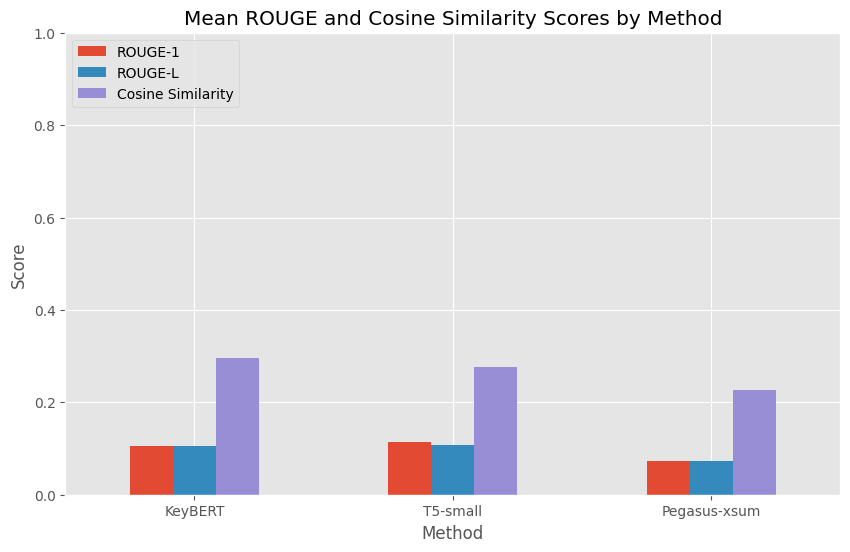

In [112]:
plot_mean_scores(df=df)

#### Box Plot: Score Distributions

In [113]:
def plot_score_distributions(df):
    """
    Plot box plots for score distributions for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    metrics = {
        "ROUGE-1": ["rouge-1-Keybert-all-MiniLM-L6-v2", "rouge-1-summarizer-t5-small", "rouge-1-summarizer-pegasus-xsum"],
        "ROUGE-L": ["rouge-L-Keybert-all-MiniLM-L6-v2", "rouge-L-summarizer-t5-small", "rouge-L-summarizer-pegasus-xsum"],
        "Cosine Similarity": ["cosine-Keybert-all-MiniLM-L6-v2", "cosine-summarizer-t5-small", "cosine-summarizer-pegasus-xsum"]
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, (metric_name, columns) in enumerate(metrics.items()):
        melted_df = pd.melt(df, value_vars=columns, var_name="Method", value_name=metric_name)
        melted_df["Method"] = melted_df["Method"].map({
            "rouge-1-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "rouge-1-summarizer-t5-small": "T5-small",
            "rouge-1-summarizer-pegasus-xsum": "Pegasus-xsum",
            "rouge-L-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "rouge-L-summarizer-t5-small": "T5-small",
            "rouge-L-summarizer-pegasus-xsum": "Pegasus-xsum",
            "cosine-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "cosine-summarizer-t5-small": "T5-small",
            "cosine-summarizer-pegasus-xsum": "Pegasus-xsum"
        })

        melted_df.boxplot(column=metric_name, by="Method", ax=axes[idx], grid=False)
        axes[idx].set_title(f"{metric_name} Distribution")
        axes[idx].set_xlabel("Method")
        axes[idx].set_ylabel("Score")
        axes[idx].set_ylim(0, 1)

    plt.suptitle("Score Distributions by Method")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

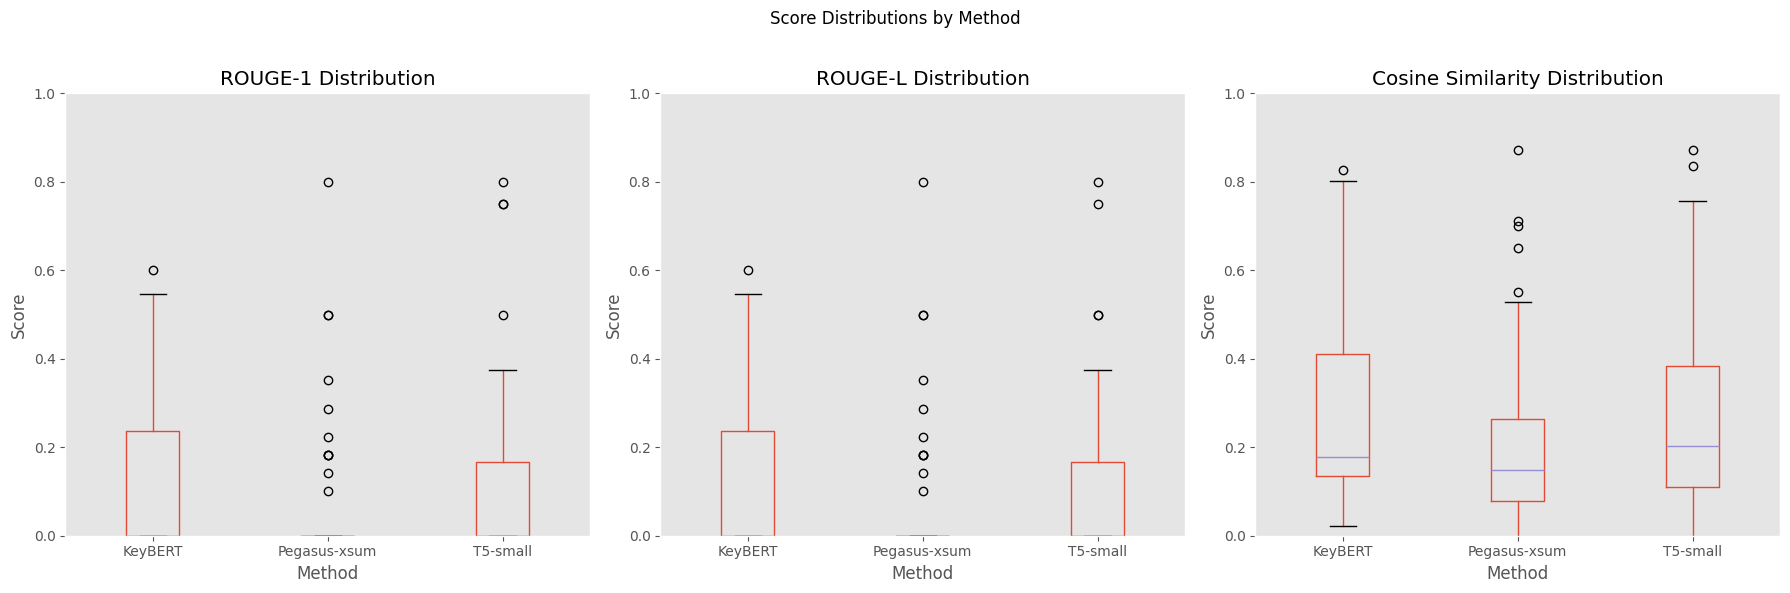

In [114]:
plot_score_distributions(df=df)

#### Scatter Plot: ROUGE vs Cosine Similarity

In [116]:
def plot_scatter_scores(df):
    """
    Scatter plot showing the relationship between ROUGE-L and Cosine Similarity scores for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    plt.figure(figsize=(10, 6))
    colors = {'KeyBERT': 'red', 'T5-small': 'blue', 'Pegasus-xsum': 'green'}

    methods = {
        "KeyBERT": ("rouge-L-Keybert-all-MiniLM-L6-v2", "cosine-Keybert-all-MiniLM-L6-v2"),
        "T5-small": ("rouge-L-summarizer-t5-small", "cosine-summarizer-t5-small"),
        "Pegasus-xsum": ("rouge-L-summarizer-pegasus-xsum", "cosine-summarizer-pegasus-xsum")
    }

    for method, (rouge_col, cosine_col) in methods.items():
        plt.scatter(df[rouge_col], df[cosine_col], label=method, color=colors[method], alpha=0.6, s=100)

    plt.title("ROUGE-L vs Cosine Similarity by Method")
    plt.xlabel("ROUGE-L Score")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(True)
    plt.show()


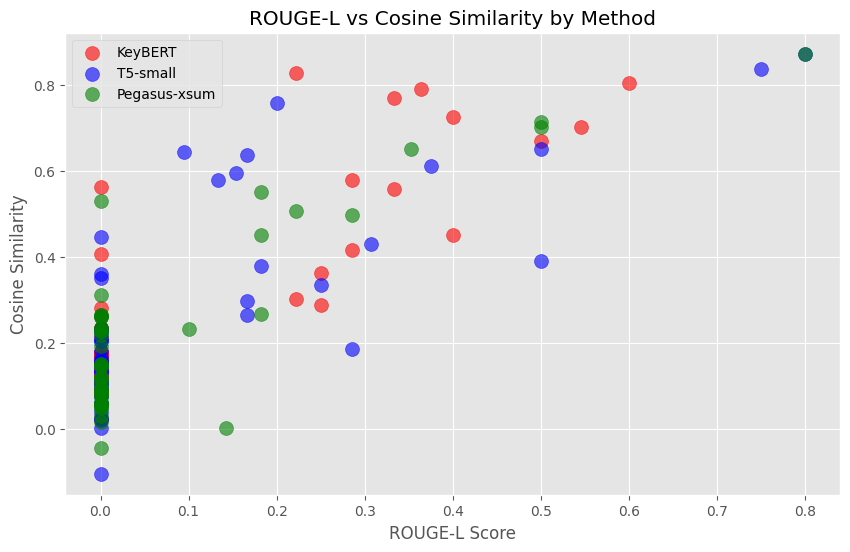

In [117]:
plot_scatter_scores(df)